## Merton Jump Diffusion Calibration
In this section, we will focus on calibrating the Merton Jump Diffusion model. The parameters we will focus on are $\lambda$, the rate of the Poisson process, and $a$ and $b$, which model the size of the jump. The following is the code to implement the stock pricing model.

For each parameter, we test different values holding the other two equal and compute the mean squared error of the estimated prices. We then plot the results in a scatter plot, to visualize which value for each parameter better fits the real data. 

Based on the plots shown, the best values for the three parameters are the following: $\lambda = 0.075, a = -0.1, b = 0.05$

In [1]:
import numpy as np
from datetime import date, timedelta, datetime
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import Data
import Price_Models as pm

n = 500 #Sample size
iterations = 100 # max tries

# Set to true to update database from online data, if false will pull data from csv files
Update = False 
trade_days = 256
est_price_path = './Data/tmp.csv'

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = date(2023,11,24)
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day

# Importing data
df = Data.GetData(start_date, df_end, trade_days, Update)
df = df[df.method == 'E']
df = df[df.lastPrice > 10]
df = df[pd.to_datetime(df.lastTradeDate).dt.date > date(2023,11,21)]
df = df.sample(n)  #Reduce data size for testing purposes
r = 0.0553


In [2]:
x1 = np.linspace(0,0.5, iterations) # Values to test lambda
x2 = np.linspace(-0.3,0.3, iterations) # Values to test a
x3 = np.linspace(-0.2,0.3, iterations) # Values to test b

def compute_errors(lamb, a, b):
    MJD_est_price = []
    
    for i in range(len(df)):
        S0 = df.iloc[i].S0       # Sets S0
        K = df.iloc[i].strike
        T = df.iloc[i].maturity / 365
        sigma = df.iloc[i].sigma
        type = df.iloc[i].optionType
        
        if df.iloc[i].method == 'E':
            computed_price_MJD = pm.MJD(S0, K, T, sigma, r, type, lamb, a, b)

        MJD_est_price.append(computed_price_MJD)

    MJD_perc_error = (df.lastPrice - MJD_est_price)/df.lastPrice
    averageMJD = np.mean((MJD_perc_error)**2)

    return averageMJD

def testvalues():
    lamb_s = 0.15
    a_s = -0.1
    b_s = -0.05
    lamb, a, b = lamb_s, a_s, b_s
    errors = compute_errors(lamb, a, b)
    df_errors_lamb = pd.DataFrame({'lamb': lamb, 'a': a, 'b': b, 'MJDerror' : errors},index=[0])

    # testing lambda values
    for i in tqdm(range(iterations)):
        # lamb += 0.1*(np.random.rand() - 0.5)
        lamb = x1[i]
        errors = compute_errors(lamb, a, b)
        df_errors_lamb.loc[i+1] = [lamb,a,b,errors]

    lamb, a, b = lamb_s, a_s, b_s
    df_errors_a = pd.DataFrame({'lamb': lamb, 'a': a, 'b': b, 'MJDerror' : errors},index=[0])

    # testing a values
    for i in tqdm(range(iterations)):
        #a += 0.2*(np.random.rand() - 0.5)
        a = x2[i]
        errors = compute_errors(lamb, a, b)
        df_errors_a.loc[i+1] = [lamb,a,b,errors]

    lamb, a, b = lamb_s, a_s, b_s
    df_errors_b = pd.DataFrame({'lamb': lamb, 'a': a, 'b': b, 'MJDerror' : errors},index=[0])

    # testing b values
    for i in tqdm(range(iterations)):
        #b += 0.2*(np.random.rand() - 0.5)
        b = x3[i]
        errors = compute_errors(lamb, a, b)
        df_errors_b.loc[i+1] = [lamb,a,b,errors]

    return df_errors_lamb, df_errors_a, df_errors_b

values = testvalues()

values_lambda = pd.DataFrame(values[0]) 
values_a = pd.DataFrame(values[1]) 
values_b = pd.DataFrame(values[2]) 


100%|██████████| 100/100 [10:19<00:00,  6.20s/it]


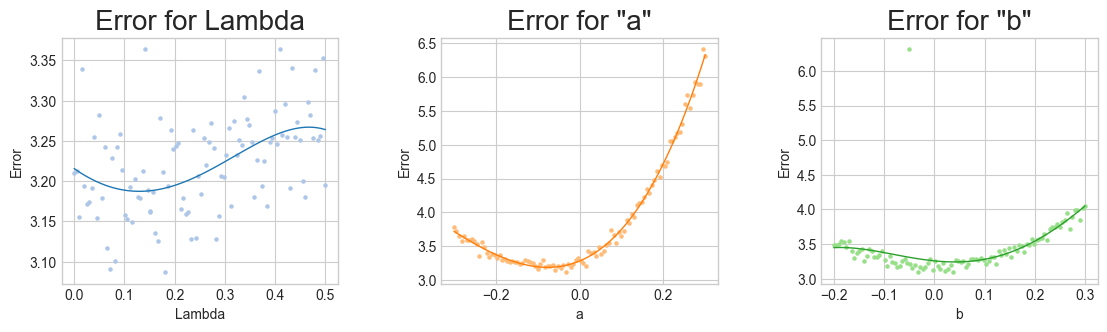

In [4]:
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
palette = sns.color_palette("tab20", 20)

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid") 

curveplot = lambda t,a,b,c,d,e: e*t**4+d*t**3+a*t**2+b*t+c
model_lamb = scipy.optimize.curve_fit(curveplot,  values_lambda.lamb,  values_lambda.MJDerror)
model_a = scipy.optimize.curve_fit(curveplot,  values_a.a,  values_a.MJDerror)
model_b = scipy.optimize.curve_fit(curveplot,  values_b.b,  values_b.MJDerror)

def CI(model, length):
    Var = []
    coef1 = []
    coef2 = []
    for i in range(length):
        Var.append(model[1][i,i])
        b=1
        a1 = model[0][i] + b*np.sqrt(Var[i])
        a2 = model[0][i] - b*np.sqrt(Var[i])
        coef1.append(a1)
        coef2.append(a2)
    coef = [coef1,coef2]
    return coef

fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
fig.tight_layout(h_pad=4, w_pad=5)

#axis[0].figure(figsize=(10, 5))
axis[0].scatter(values_lambda.lamb, values_lambda.MJDerror, s = 5, color = palette[1])
axis[0].plot(x1, curveplot(x1,*model_lamb[0]), '-',linewidth=1, color = palette[0])
# axis[0].plot(x1, curveplot(x1,*CI(model_lamb,3)[0]), '--',linewidth=0.6, color = 'tab:purple')
# axis[0].plot(x1, curveplot(x1,*CI(model_lamb,3)[1]), '--',linewidth=0.6, color = 'tab:purple')
axis[0].set_title('Error for Lambda', fontsize = 20)
axis[0].set_xlabel('Lambda')
axis[0].set_ylabel('Error')
#plt.legend()
#axis[0].savefig('./Data/MJD_lambda_error.png', dpi = 300, transparent = False)
#plt.show()

#plt.figure(figsize=(10, 5))
axis[1].scatter(values_a.a, values_a.MJDerror, s = 5, color = palette[3])
axis[1].plot(x2, curveplot(x2,*model_a[0]), '-',linewidth=1, color = palette[2])
#plt.plot(x2, curveplot(x2,*CI(model_a,3)[0]), '--',linewidth=0.6, color = 'tab:purple')
#plt.plot(x2, curveplot(x2,*CI(model_a,3)[1]), '--',linewidth=0.6, color = 'tab:purple')
axis[1].set_title('Error for "a"', fontsize = 20)
axis[1].set_xlabel('a')
axis[1].set_ylabel('Error')
#plt.legend()
# plt.savefig('./Data/MJD_a_error.png', dpi = 300, transparent = False)
# plt.show()

# plt.figure(figsize=(10, 5))
axis[2].scatter(values_b.b, values_b.MJDerror, s = 5, color = palette[5])
plt.plot(x3, curveplot(x3,*model_b[0]), '-',linewidth=1, color = palette[4])
#plt.plot(x3, curveplot(x3,model_b[0][0], CI(model_b,3)[0][1], 1.01*CI(model_b,3)[0][2]), '--',linewidth=0.6, color = 'tab:purple')
#plt.plot(x3, curveplot(x3,model_b[0][0], CI(model_b,3)[1][1], 0.98*CI(model_b,3)[0][2]), '--',linewidth=0.6, color = 'tab:purple')
axis[2].set_title('Error for "b"', fontsize = 20)
axis[2].set_xlabel('b')
axis[2].set_ylabel('Error')
#plt.legend()
fig.savefig('./Presentation Files/MJD_calibration.png', dpi = 300, bbox_inches='tight')